%pip install torchtext
%pip install wandb

In [1]:
import pandas as pd
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import wandb
import nltk
nltk.download('punkt')
wandb.login()
wandb.init(project="art-test-caption")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

vocab,embeddings = [],[]
with open('glove.6B.50d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

import numpy as np
vocab = np.array(vocab)
embs = np.array(embeddings)

#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab = np.insert(vocab, 0, '<pad>')
vocab = np.insert(vocab, 1, '<unk>')
print(vocab[:10])

pad_emb = np.zeros((1,embs.shape[1]))   #embedding for '<pad>' token.
unk_emb = np.mean(embs,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs = np.vstack((pad_emb,unk_emb,embs))
print(embs.shape)

In [2]:
data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
data = data[:3000]
data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE': 'title', 'TECHNIQUE':'style','URL':'description'})
data = data[['image','description']]
data['image'] = [f'.{x}' for x in data['image']]
print(f'columns:{[x for x in data.columns]}')

columns:['image', 'description']


In [3]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

img_tr = [transform(Image.open(img)) for img in tqdm(data['image'])]

mean,std = img_tr[0].mean(),img_tr[0].std()

100%|██████████| 3000/3000 [00:33<00:00, 90.15it/s] 


In [4]:
mean,std = img_tr[0].mean([1,2]),img_tr[0].std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4685, 0.3801, 0.3472])
Std of the image: tensor([0.2129, 0.1872, 0.1589])


In [5]:
# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(data['image'],data['description'], test_size=0.2, random_state=42)

In [6]:
#Image Transformations
img_train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

img_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

In [7]:
from nltk.tokenize import word_tokenize
class Vocabulary:
    
    def __init__(self, name):
        self.name = name
        PAD_token = 0   # Used for padding short sentences
        SOS_token = 1   # Start-of-sentence token
        EOS_token = 2   # End-of-sentence token
        self.word2index = {"PAD": PAD_token, "SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence.split(' '):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]
    
    def len(self):
        return self.num_words

vocab = Vocabulary('art')
for sentence in tqdm(data['description']):
    sentence = word_tokenize(sentence)
    for word in sentence:
        vocab.add_word(word)

100%|██████████| 3000/3000 [00:01<00:00, 2489.63it/s]


In [8]:
from nltk.tokenize import word_tokenize
class ArtDataset(torch.utils.data.Dataset):

    def __init__(self,images,labels,transform=None, max_caption_length=50):
        self.data = images
        self.labels = labels
        self.transform = transform
        self.max_caption_length = max_caption_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_pil = Image.open(self.data[index])
        img_pil = img_pil.convert('RGB')
        if self.transform is not None:
            img_pil = self.transform(img_pil)
        else:
            tr1 = transforms.ToTensor()
            img_pil = tr1(img_pil)

        #Tokenize caption using nltk
        caption = self.labels[index]
        tokens = []
        tokens.append('SOS')
        tokens.extend(word_tokenize(caption))
        tokens.append('EOS')
        if len(tokens) > self.max_caption_length:
            tokens = tokens[:self.max_caption_length]
        else:
            tokens += ["PAD"] * (self.max_caption_length - len(tokens))
        #Convert tokens to indices
        caption = [vocab.to_index(token) for token in tokens]

        tokenized_caption = torch.LongTensor(caption)
        return(img_pil,tokenized_caption)

train_dataset = ArtDataset(X_train.values,y_train.values,transform=img_train_transform)
val_dataset = ArtDataset(X_val.values,y_val.values,transform=img_test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([50, 3, 256, 256])
Labels batch shape: 50


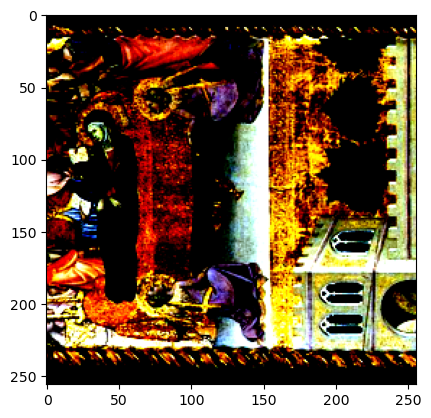

Label_tokenized: tensor([[    1,     3,  1097,  ...,     0,     0,     0],
        [    1,   276,    63,  ...,   111,  3269,   375],
        [    1,  6148, 11258,  ...,   292, 11270,   818],
        ...,
        [    1,     3,   917,  ...,   296,    19,     3],
        [    1,   907, 15417,  ...,  1695, 15425,    19],
        [    1, 20996,   125,  ...,  6339,   910,     5]])


In [9]:
batch_size = 50
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
features, labels = next(iter(trainloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {len(labels)}")
img = features[0].squeeze()
plt.imshow(img.permute(*torch.arange(img.ndim - 1, -1, -1)))
plt.show()
print(f"Label_tokenized: {labels}")
#print(f"Label: {[vocab.to_word(x) for x in labels[0]]}")

In [10]:
del data
del X_train,X_val,y_train,y_val

## Show Attend and Tell model V2

In [11]:
class Encoder(nn.Module):
    def __init__(self, embed_dim) -> None:
        super(Encoder,self).__init__()
        resnet = torchvision.models.resnet50(weights="ResNet50_Weights.DEFAULT")
        for param in resnet.parameters():
            param.requires_grad = False
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features*8*8,embed_dim)
        self.batch = nn.BatchNorm1d(embed_dim,momentum=0.01)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((embed_dim,embed_dim))
        self.dropout = nn.Dropout(0.5)
        self.embed.weight.data.normal_(0.0,0.02)
        self.embed.bias.data.fill_(0)


    def forward(self,imgs):

        features = self.resnet(imgs)
        features = features.view(features.size(0),-1)
        features = self.embed(self.dropout(features))
        features = self.batch(features)
        
        return features

In [12]:
class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim) -> None:
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)#U
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)#W
        self.full_att = nn.Linear(attention_dim,1)#V
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)
        att = self.relu(att1+att2)
        att = self.full_att(att).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha).sum(dim=1)

        return attention_weighted_encoding, alpha
        

In [13]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(Decoder, self).__init__()

        self.attention = Attention(embed_size, hidden_size, hidden_size)

        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.f_beta = nn.Linear(hidden_size, embed_size)
        self.sigmoid = nn.Sigmoid()


        self.embed.weight.data.uniform_(-0.1,0.1)
        self.linear.weight.data.uniform_(-0.1,0.1)
        self.linear.bias.data.fill_(0)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        features = features.unsqueeze(1)
        embeddings = torch.cat((features, embeddings[:,:-1,:]), dim=1)
        hidden, c = self.lstm(embeddings)
            
        attention_weighted_encoding, alpha = self.attention(features, hidden)
        
        gate = self.sigmoid(self.f_beta(hidden))
        
        attention_weighted_encoding = gate * attention_weighted_encoding
        
        hidden,c = self.lstm(torch.cat((embeddings, attention_weighted_encoding)))
        outputs = self.linear(self.dropout(hidden))
        
        return outputs
    
    def sample(self,features):
        output = []
        batch_size = features.shape[0]
        hidden = (torch.randn(1,batch_size,self.hidden_size).to(device),
                  torch.randn(1,batch_size,self.hidden_size).to(device))
        inputs = features.unsqueeze(1)
        while True:
            lstm_out, hidden = self.lstm(inputs,hidden)
            outputs = self.linear(lstm_out)
            out = outputs.squeeze(1)
            _, argmax = torch.max(out,dim=1)
            
            output.append(argmax.cpu().numpy()[0].item())
            if (argmax.cpu().numpy()[0].item() == 2 or len(output) > 50):
                break
            inputs = self.embed(argmax).unsqueeze(1)
        return output
    #Beam Search
    def sample_beam_search(self,features,beam_size=3):
        output = []
        batch_size = features.shape[0]
        hidden = (torch.randn(1,batch_size,self.hidden_size).to(device),
                  torch.randn(1,batch_size,self.hidden_size).to(device))
        inputs = features.unsqueeze(1)

        while True:
            lstm_out, hidden = self.lstm(inputs,hidden)
            outputs = self.linear(lstm_out)
            out = outputs.squeeze(1)
            _, argmax = torch.max(out,dim=1)
            output.append(argmax.cpu().numpy()[0].item())
            if (argmax.cpu().numpy()[0].item() == 2 or len(output) > 50):
                break
            inputs = self.embed(argmax).unsqueeze(1)
        return output


In [14]:
train_loss = []
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    decoder.train()
    encoder.train()

    losses = []
    
    with tqdm(total=len(train_loader)) as pbar:
        for i, (imgs, caps) in enumerate(train_loader):
            imgs = imgs.to(device)
            caps = caps.to(device)

            decode_lengths = [len(cap) for cap in caps]

            imgs = encoder(imgs)
            scores = decoder(imgs,caps)
            scores = nn.utils.rnn.pack_padded_sequence(scores, decode_lengths, batch_first=False, enforce_sorted=False)
            caps = nn.utils.rnn.pack_padded_sequence(caps, decode_lengths, batch_first=True, enforce_sorted=False)
            
            #loss = torch.autograd.Variable(criterion(scores.max(1)[1].float(),caps[0]),requires_grad=True)
            #loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
            loss = torch.autograd.Variable(criterion(scores.data,caps.data),requires_grad=True)
            decoder_optimizer.zero_grad()
            if encoder_optimizer is not None:
                encoder_optimizer.zero_grad()
            loss.backward()

            # if grad_clip is not None:
            #     clip_gradient(decoder_optimizer, grad_clip)
            #     if encoder_optimizer is not None:
            #         clip_gradient(encoder_optimizer, grad_clip)
            
            decoder_optimizer.step()
            if encoder_optimizer is not None:
                encoder_optimizer.step()

            losses.append(loss.item())
            pbar.set_description(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item()}")
            wandb.log({"Batch_loss": loss.item()})
            pbar.update(1)
    train_loss.append(np.mean(losses))

        


## Train and Hyperparams

In [15]:
#Parameters and Hyperparameters

#Model Parameters
embed_dim = 100
attention_dim = 256
decoder_dim = 256
dropout = 0.5

#Training Hyperparameters
epochs = 2
encoder_lr = 1e-4
decoder_lr = 4e-4
alpha_c = 1.0
fine_tune_encoder = False
checkpoint = None


In [16]:
# run = wandb.init(
#     project='Art',
#     config={
#         "learning_rage": 0.001,
#         "epochs": 2,
#     }
# )

decoder = Decoder(embed_size=embed_dim,hidden_size=decoder_dim,vocab_size=vocab.len())
decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),lr=decoder_lr)

encoder = Encoder(embed_dim)
#encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),lr=encoder_lr) if fine_tune_encoder else None

decoder = decoder.to(device)
encoder = encoder.to(device)

criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    train(trainloader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch)
    # wandb.log({"train_loss": train_loss[epoch]})
    

Epoch: 2, Batch: 48, Loss: 10.01977252960205: 100%|██████████| 48/48 [03:17<00:00,  4.12s/it] 


In [17]:
#Define the evaluation function
def evaluate(valloader,encoder, decoder, loss_fn):
    with torch.no_grad():
        for i, (images,descriptions) in enumerate(valloader):
            images = images.to(device)
            descriptions = descriptions.to(device)
            features = encoder(images)
            outputs = decoder(features,descriptions)

            decode_lengths = [len(cap) for cap in descriptions]

            outputs = nn.utils.rnn.pack_padded_sequence(outputs, decode_lengths, batch_first=False, enforce_sorted=False)
            descriptions = nn.utils.rnn.pack_padded_sequence(descriptions, decode_lengths, batch_first=True, enforce_sorted=False)

            loss = loss_fn(outputs.data,descriptions.data)
            print(f'Batch: {i}, Loss: {loss.item()}')
            wandb.log({"Eval_Batch_loss": loss.item()})

In [18]:
evaluate(testloader,encoder,decoder,criterion)

Batch: 0, Loss: 10.021224021911621
Batch: 1, Loss: 10.02192211151123
Batch: 2, Loss: 10.021387100219727
Batch: 3, Loss: 10.020561218261719
Batch: 4, Loss: 10.021685600280762
Batch: 5, Loss: 10.020838737487793
Batch: 6, Loss: 10.021452903747559
Batch: 7, Loss: 10.022254943847656
Batch: 8, Loss: 10.021110534667969
Batch: 9, Loss: 10.020648002624512
Batch: 10, Loss: 10.021133422851562
Batch: 11, Loss: 10.022132873535156


In [19]:
#Define the function to convert the predicted ids to words
def convert_to_words(sampled_ids):
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.index2word[word_id]
        sampled_caption.append(word)
        if word == 'EOS':
            break
    sentence = ' '.join(sampled_caption)
    return sentence

In [20]:
#Define the function to display the image and the predicted caption
def display_image_caption(image,sentence):
    #plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(sentence)
    plt.show()

In [21]:
#Define the function to display the image and the actual caption
def display_image_caption_actual(image, label):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(convert_to_words(label.cpu().numpy()))
    plt.show()

In [22]:
#Define the prediction function
def predict(encoder, decoder,image):
    encoder.eval()
    decoder.eval()
    image = image.to(device)
    feature = encoder(image)
    sampled_ids = []
    states = None
    
    sampled_ids = decoder.sample_beam_search(feature)
    return sampled_ids

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


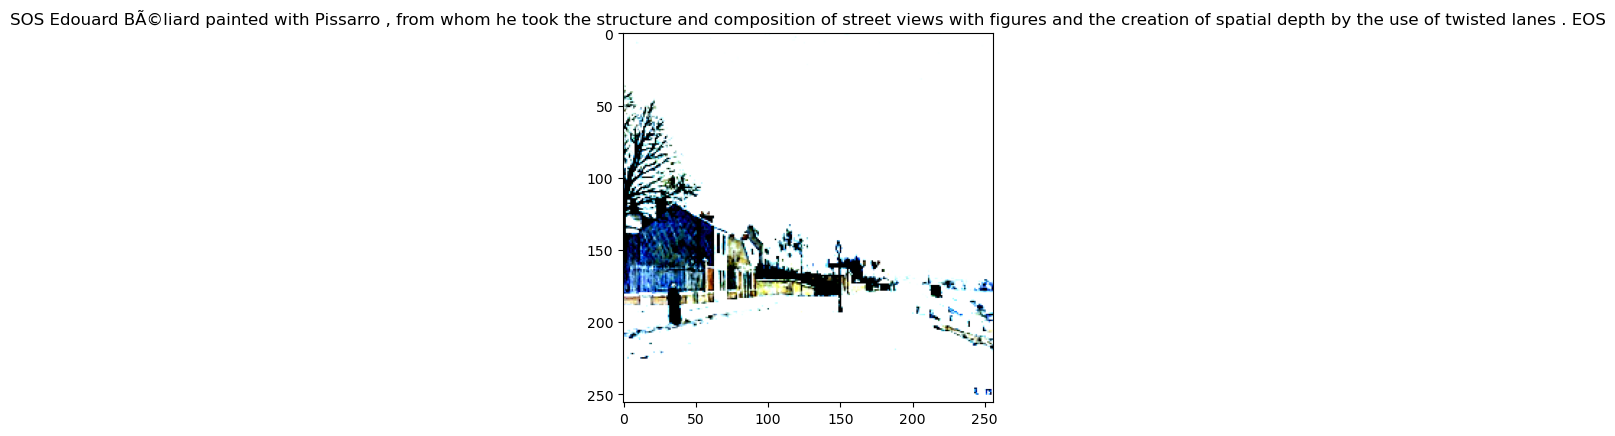

Predicted: satires satires satires satires stars Guidottiin placed rein rein rein rein Susanna Susanna slim 1380-85 rein rein Susanna Susanna slim Susanna slim Modest 1380-85 rein rein rein Susanna Susanna slim Susanna slim Modest 1380-85 rein rein rein Susanna Susanna slim Susanna slim Modest 1380-85 rein rein rein Susanna Susanna slim Susanna


In [23]:

img, label = next(iter(testloader))
display_image_caption_actual(img[0], label[0])
res = predict(encoder,decoder,img)
sentence = convert_to_words(res)
print(f"Predicted: {sentence}")